## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

You can get the data via:

    wget http://pjreddie.com/media/files/cifar.tgz    
**Important:** Before proceeding, the student must reorganize the downloaded dataset files to match the expected directory structure, so that there is a dedicated folder for each class under 'test' and 'train', e.g.:

```
* test/airplane/airplane-1001.png
* test/bird/bird-1043.png

* train/bird/bird-10018.png
* train/automobile/automobile-10000.png
```

The filename of the image doesn't have to include its class.

In [2]:
import os
import shutil
import sys

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
PATH = "/home/akash/data/cifar10/"

In [5]:
os.path.join(PATH, 'train' ,'16652_horse.png' )

'/home/akash/data/cifar10/train/16652_horse.png'

In [6]:
def to_label_subdirs(path, subdirs, classes, labelfn):
    for sd in subdirs:
        for rf in os.listdir(os.path.join(path, sd)):
            af = os.path.join(path, sd, rf)
            if not os.path.isfile(af):
                continue
            lb = labelfn(rf)
            if not lb:
                continue
            os.renames(af, os.path.join(path, sd, lb, rf))
            

In [7]:
to_label_subdirs(PATH, 'train test'.split(), classes, lambda f: f[f.find('_')+1 : f.find('.')])

In [8]:
!find {PATH}train {PATH}test -maxdepth 1 -type f | wc -l

0


In [9]:
from fastai.conv_learner import *

os.makedirs(PATH,exist_ok=True)

!ls {PATH}

if not os.path.exists(f"{PATH}/train/bird"):
   raise Exception("expecting class subdirs under 'train/' and 'test/'")
!ls {PATH}/train

labels.txt  models  test  tmp  train
airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck


In [10]:
folders = !ls {PATH}train
folders

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [11]:
from scipy import ndimage, misc
images = []
for folder in folders:
    for img in os.listdir(os.path.join(PATH,*["train", folder])):
        filepath  =  os.path.join(PATH,*["train", folder,img])
        img = ndimage.imread(filepath,mode="RGB")
        images.append(img)

print (len(images))

/home/akash/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


50000


### Calculate Stats
To calculate the train mean and standard deviation, per channel, for normalizing:
* Divide by 255 to make pixel values between 0 and 1.
* reshape image appropriately. The orig imgs are as (-1, height, width, channel). We reshape to make channel major format to help in conputation by using transpose.
* Flatten all 50,000 images channel wise so we get 3 vectors of size 50000 * 32 * 32, one per each channel.
* Take mean and std. of the three vectors.

In [12]:
imgs = np.stack(images, axis = 0)
print(imgs.shape)
imgs = imgs/255
imgs = imgs.transpose(3,0,1,2)
print (imgs.shape)
imgs = np.reshape(imgs, (3,-1))
print (imgs.shape)

(50000, 32, 32, 3)
(3, 50000, 32, 32)
(3, 51200000)


In [13]:
np.mean(imgs,1), np.std(imgs,1)

(array([0.4914 , 0.48216, 0.44653]), array([0.24703, 0.24349, 0.26159]))

In [14]:
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [15]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [16]:
bs=256

### Look at data

In [17]:
data = get_data(32,4)

In [18]:
x,y=next(iter(data.trn_dl))

In [19]:
x.size()

torch.Size([4, 3, 32, 32])

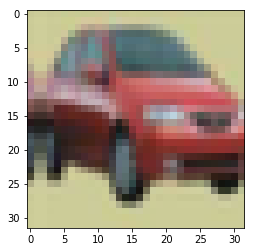

In [20]:
plt.imshow(data.trn_ds.denorm(x)[0]);

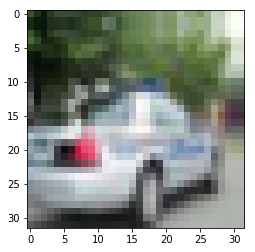

In [21]:
plt.imshow(data.trn_ds.denorm(x)[1]);

## Fully connected model

In [22]:
data = get_data(32,bs)

In [23]:
lr=1e-2

From [this notebook](https://github.com/KeremTurgutlu/deeplearning/blob/master/Exploring%20Optimizers.ipynb) by our student Kerem Turgutlu:

In [24]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        #Flatten the data to (batch_size, as manxy pixels in an image): x.size(0), -1
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [25]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

In [26]:
learn

SimpleNet(
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=10, bias=True)
  )
)

In [27]:
[o.numel() for o in learn.model.parameters()]

[122880, 40, 400, 10]

In [28]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [29]:
learn.lr_find()

 74%|███████▍  | 145/196 [00:24<00:32,  1.58it/s, loss=2.15]

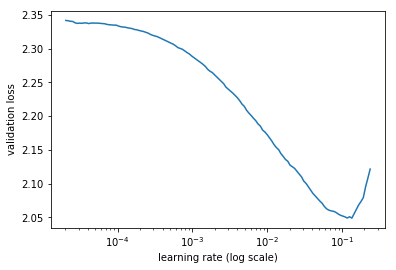

In [30]:
learn.sched.plot()

In [31]:
%time learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.757732   1.643755   0.4231    
    1      1.674402   1.564626   0.4457                     
CPU times: user 1min 39s, sys: 59 s, total: 2min 38s
Wall time: 1min 12s


[array([1.56463]), 0.4457]

In [32]:
%time learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.606597   1.511625   0.4695    
    1      1.585551   1.49163    0.4764                     
CPU times: user 1min 41s, sys: 59.2 s, total: 2min 40s
Wall time: 1min 12s


[array([1.49163]), 0.4764]

## CNN

In [33]:
nn.Conv2D()

Object `nn.Conv2D` not found.


In [34]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        ## Flatten to batch_size (num_filters)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [35]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

In [36]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

In [37]:
learn.lr_find(end_lr=100)

 70%|██████▉   | 137/196 [00:22<00:11,  5.17it/s, loss=2.51]

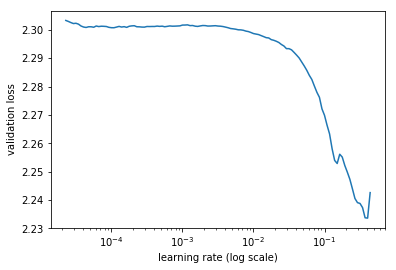

In [38]:
learn.sched.plot()

In [39]:
%time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.726603   1.607561   0.4139    
    1      1.529878   1.455166   0.4773                     
CPU times: user 1min 43s, sys: 59.1 s, total: 2min 43s
Wall time: 1min 13s


[array([1.45517]), 0.4773]

In [40]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.424702   1.356131   0.5104    
    1      1.323112   1.259906   0.5483                     
    2      1.290824   1.219252   0.5592                     
    3      1.256323   1.185877   0.5747                     
CPU times: user 3min 26s, sys: 1min 57s, total: 5min 24s
Wall time: 2min 24s


[array([1.18588]), 0.5747]

## Refactored

In [44]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

In [45]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        
        ## Flatten to (batch_size, num channels/feature maps/kernels)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [46]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [47]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [48]:
%time learn.fit(1e-1, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.746429   1.650747   0.4045    
    1      1.532661   1.541101   0.4408                     
CPU times: user 1min 45s, sys: 58.7 s, total: 2min 43s
Wall time: 1min 13s


[array([1.5411]), 0.4408]

In [49]:
%time learn.fit(1e-1, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.719375   1.617665   0.4097    
    1      1.453449   1.368964   0.5065                     
CPU times: user 1min 44s, sys: 59.2 s, total: 2min 43s
Wall time: 1min 13s


[array([1.36896]), 0.5065]

## BatchNorm

In [50]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        ### channel/filter means & stds.
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [51]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        # One conv layer with large kernel size so that we start off with richer input.
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        
        #BN layers
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [52]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [53]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
              OrderedDict([

In [54]:
%time learn.fit(3e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.509907   1.327657   0.5252    
    1      1.287007   1.181638   0.5781                     
CPU times: user 2min 9s, sys: 59.7 s, total: 3min 9s
Wall time: 1min 16s


[array([1.18164]), 0.5781]

In [55]:
%time learn.fit(1e-1, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.212171   1.082202   0.6178    
    1      1.075993   0.991123   0.6485                     
    2      1.005255   0.927656   0.6759                     
    3      0.950211   0.87721    0.6951                      
CPU times: user 4min 15s, sys: 1min 59s, total: 6min 15s
Wall time: 2min 32s


[array([0.87721]), 0.6951]

## Deep BatchNorm

In [63]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], stride=1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [64]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [65]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('BnLayer-5',
              OrderedDict

In [66]:
%time learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.532506   1.439639   0.4827    
    1      1.306892   1.216758   0.5596                     
CPU times: user 2min 37s, sys: 58.4 s, total: 3min 35s
Wall time: 1min 18s


[array([1.21676]), 0.5596]

In [67]:
%time learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.11075    1.057019   0.6211    
    1      1.037583   0.97999    0.6456                     
CPU times: user 2min 36s, sys: 58.9 s, total: 3min 35s
Wall time: 1min 18s


[array([0.97999]), 0.6456]

## Resnet

In [68]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [69]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        # one large kernel to start with
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        
        # this layer has stride = 2 and reduces image size
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        
        ## The following layers have stride =1 and thus do nto affect image size
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [70]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [71]:
wd=1e-5

In [72]:
%time learn.fit(1e-2, 2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.567275   1.405729   0.4882    
    1      1.338552   1.308191   0.5205                     
CPU times: user 2min 51s, sys: 1min 1s, total: 3min 52s
Wall time: 1min 31s


[array([1.30819]), 0.5205]

In [73]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.176757   1.120452   0.5954    
    1      1.114059   1.021313   0.6372                     
    2      0.998706   0.985636   0.651                       
    3      1.036807   0.955305   0.6646                     
    4      0.938541   0.89734    0.6793                      
    5      0.849719   0.851727   0.6996                      
    6      0.803213   0.835872   0.7068                      
CPU times: user 9min 54s, sys: 3min 32s, total: 13min 27s
Wall time: 5min 15s


[array([0.83587]), 0.7068]

In [74]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.895513   0.908566   0.6842    
    1      0.817162   0.804711   0.7184                      
    2      0.729086   0.742384   0.7417                      
    3      0.677118   0.73252    0.7458                      
    4      0.801985   0.829558   0.7117                      
    5      0.701187   0.71533    0.7553                      
    6      0.628794   0.732656   0.7513                      
    7      0.588494   0.654305   0.7716                      
    8      0.696529   0.760826   0.7369                      
    9      0.636408   0.6575     0.7711                      
    10     0.563368   0.63138    0.7821                      
    11     0.52915    0.63406    0.7784                      
    12     0.644086   0.70958    0.7579                      
    13     0.573906   0.665544   0.7753                      
    14     0.513294   0.606569   0.7953                      
    15     0.46928    0.62

[array([0.55716]), 0.8189]

## Resnet 2

In [75]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [76]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [77]:
wd=1e-6

In [78]:
%time learn.fit(1e-2, 2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.608895   1.433763   0.4865    
    1      1.379142   1.232105   0.5601                     
CPU times: user 3min 16s, sys: 1min 3s, total: 4min 20s
Wall time: 1min 46s


[array([1.2321]), 0.5601]

In [79]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

epoch      trn_loss   val_loss   accuracy                   
    0      1.150409   1.067374   0.6184    
    1      1.125816   1.027231   0.6337                     
    2      0.972073   0.921536   0.6718                      
    3      1.034084   0.946074   0.6647                     
    4      0.900769   0.876713   0.6975                      
    5      0.801129   0.769255   0.736                       
    6      0.754544   0.756759   0.7356                      
CPU times: user 11min 26s, sys: 3min 40s, total: 15min 7s
Wall time: 6min 11s


[array([0.75676]), 0.7356]

In [80]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

epoch      trn_loss   val_loss   accuracy                    
    0      0.85906    0.802857   0.7233    
    1      0.776389   0.727428   0.7484                      
    2      0.691549   0.692756   0.7599                      
    3      0.654179   0.695266   0.7584                      
    4      0.753512   0.728428   0.7496                      
    5      0.686031   0.656457   0.7723                      
    6      0.604448   0.634893   0.7788                      
    7      0.569275   0.605766   0.7914                      
    8      0.682645   0.679325   0.7614                      
    9      0.609374   0.62849    0.7798                      
    10     0.542526   0.593501   0.7979                      
    11     0.511676   0.590513   0.798                       
    12     0.612572   0.619947   0.7862                      
    13     0.552501   0.616799   0.7901                      
    14     0.488905   0.555892   0.8085                      
    15     0.451224   0.55

[array([0.4739]), 0.8366]

In [81]:
learn.save('tmp3')

In [82]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [83]:
metrics.log_loss(y,preds), accuracy_np(preds,y)

(0.4278121527579479, 0.8555)

### End